# Testing
### Leerstehende Wohnungen nach Stadtquartier, Zimmerzahl, Gebäudeart, Bewohnungsart und Gebäudealter

https://data.stadt-zuerich.ch/dataset/bau_leerwhg_whg_quartier_zizahl_efh_nb_we_od5427

Datum: 25.08.2022

### Importiere die notwendigen Packages

In [ ]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [9]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [10]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [11]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [12]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [13]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [14]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 8 datenstand:  6 time.struct_time(tm_year=2022, tm_mon=8, tm_mday=30, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=242, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [15]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [16]:
package_name = "bau_leerwhg_whg_quartier_zizahl_efh_nb_we_od5427"

In [17]:
dataset_name = "BAU542OD5427.csv"

**Statische Pfade in DWH-Dropzones**

In [18]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [19]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [20]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [21]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [22]:
from IPython.display import Markdown as md

In [23]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_leerwhg_whg_quartier_zizahl_efh_nb_we_od5427 

In [24]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_leerwhg_whg_quartier_zizahl_efh_nb_we_od5427 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [28]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [29]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_leerwhg_whg_quartier_zizahl_efh_nb_we_od5427/download/BAU542OD5427.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [31]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
QuarSort                    int64
QuarLang                   object
KreisSort                   int64
KreisLang                  object
Zimmerzahl                 object
Fl_EFH                      int64
Fl_Eigentum                 int64
Fl_Neubau                   int64
AnzWhgLeer                  int64
AnzWhgBestand               int64
dtype: object

Berechne weitere Attribute falls notwendig

In [58]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
QuarSort                        int64
QuarLang                       object
KreisSort                       int64
KreisLang                      object
Zimmerzahl                     object
Fl_EFH                          int64
Fl_Eigentum                     int64
Fl_Neubau                       int64
AnzWhgLeer                      int64
AnzWhgBestand                   int64
StichtagDatJahr_str            object
dtype: object

In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [59]:
#data2betested.head(6)

In [60]:
data2betested.shape

(8269, 12)

Beschreibe einzelne Attribute

In [61]:
data2betested.describe()

,QuarSort,KreisSort,Fl_EFH,Fl_Eigentum,Fl_Neubau,AnzWhgLeer,AnzWhgBestand
count,8269,8269,8269,8269,8269,8269,8269
mean,70,7,0,0,0,0,243
std,35,3,0,0,0,2,647
min,11,1,0,0,0,0,0
25%,34,3,0,0,0,0,5
50%,72,7,0,0,0,0,26
75%,101,10,1,1,1,0,121
max,123,12,1,1,1,49,6634


Wie viele Nullwerte gibt es im Datensatz?

In [62]:
data2betested.isnull().sum()

StichtagDatJahr        0
QuarSort               0
QuarLang               0
KreisSort              0
KreisLang              0
Zimmerzahl             0
Fl_EFH                 0
Fl_Eigentum            0
Fl_Neubau              0
AnzWhgLeer             0
AnzWhgBestand          0
StichtagDatJahr_str    0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [63]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [64]:
data2betested['StichtagDatJahr_str'] = data2betested.index.strftime("%Y-06-01")

In [65]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8269 entries, 2022-01-01 to 2014-01-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   QuarSort             8269 non-null   int64 
 1   QuarLang             8269 non-null   object
 2   KreisSort            8269 non-null   int64 
 3   KreisLang            8269 non-null   object
 4   Zimmerzahl           8269 non-null   object
 5   Fl_EFH               8269 non-null   int64 
 6   Fl_Eigentum          8269 non-null   int64 
 7   Fl_Neubau            8269 non-null   int64 
 8   AnzWhgLeer           8269 non-null   int64 
 9   AnzWhgBestand        8269 non-null   int64 
 10  StichtagDatJahr_str  8269 non-null   object
dtypes: int64(7), object(4)
memory usage: 775.2+ KB


Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [29]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [66]:
data2betested.loc["2014":year_today].head(5)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarLang,KreisSort,KreisLang,Zimmerzahl,Fl_EFH,Fl_Eigentum,Fl_Neubau,AnzWhgLeer,AnzWhgBestand,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,
2022-01-01,123,Hirzenbach,12,Kreis 12,6+,1,1,0,0,14,2022-06-01
2022-01-01,41,Werd,4,Kreis 4,2,0,0,0,1,584,2022-06-01
2022-01-01,52,Escher Wyss,5,Kreis 5,2,0,0,0,0,681,2022-06-01
2022-01-01,52,Escher Wyss,5,Kreis 5,1,0,1,1,0,0,2022-06-01
2022-01-01,52,Escher Wyss,5,Kreis 5,1,0,1,0,0,42,2022-06-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Leerwohnungen

In [67]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2014":year_today]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','Zimmerzahl']) \
    .agg(sum_AnzWhgLeer =('AnzWhgLeer', 'sum')) \
    .sort_values('StichtagDatJahr_str', ascending=False) 

myAgg.reset_index().head(3)
#myAgg.reset_index().query('sum_AnzWhgLeer > 0')

,StichtagDatJahr,StichtagDatJahr_str,Zimmerzahl,sum_AnzWhgLeer
0,2022-01-01,2022-06-01,6+,4
1,2022-01-01,2022-06-01,5,11
2,2022-01-01,2022-06-01,4,23


In [68]:
myTitle="Leerwohnungen nach Zimmerzahl"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ProjStatus'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzWhgLeer > 0'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzWhgLeer', axis=alt.Axis(title='Anz. Leerwohnungen'))
    , color=alt.Color('Zimmerzahl', legend=alt.Legend(title="Projektstatus", orient="right"))  
    , tooltip=['StichtagDatJahr', 'Zimmerzahl','sum_AnzWhgLeer']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.9), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung aller Leerwohnungen nach Stadtkreis

In [69]:
data2betested.columns

Index(['QuarSort', 'QuarLang', 'KreisSort', 'KreisLang', 'Zimmerzahl', 'Fl_EFH', 'Fl_Eigentum',
       'Fl_Neubau', 'AnzWhgLeer', 'AnzWhgBestand', 'StichtagDatJahr_str'],
      dtype='object')

In [70]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2014":year_today]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','KreisSort', 'KreisLang']) \
    .agg(sum_AnzWhgLeer =('AnzWhgLeer', 'sum')) \
    .sort_values('StichtagDatJahr_str', ascending=False) 

myAgg.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisSort,KreisLang,sum_AnzWhgLeer
0,2022-01-01,2022-06-01,12,Kreis 12,18
1,2022-01-01,2022-06-01,6,Kreis 6,5
2,2022-01-01,2022-06-01,1,Kreis 1,5


In [71]:
myTitle="Entwicklung aller Leerwohnungen nach Stadtkreis"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ProjStatus'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzWhgLeer > 0'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzWhgLeer', axis=alt.Axis(title='Anz. Leerwohnungen'))
    , color=alt.Color('KreisLang', legend=alt.Legend(title="Stadtkreis", orient="right"))  
    , tooltip=['StichtagDatJahr', 'KreisSort', 'KreisLang','sum_AnzWhgLeer']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.9), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [72]:
myAggBar = data2betested.loc[year_today]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','KreisSort', 'KreisLang','Zimmerzahl']) \
    .agg(sum_AnzWhgLeer =('AnzWhgLeer', 'sum')) \
    .sort_values('StichtagDatJahr_str', ascending=False) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisSort,KreisLang,Zimmerzahl,sum_AnzWhgLeer
0,2022-01-01,2022-06-01,1,Kreis 1,1,1
1,2022-01-01,2022-06-01,1,Kreis 1,2,2
2,2022-01-01,2022-06-01,9,Kreis 9,5,2


In [73]:
#help(sns.catplot)     

In [74]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

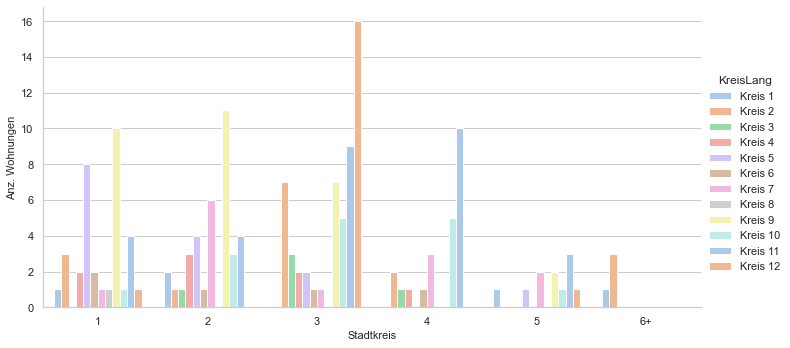

In [75]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Zimmerzahl"
            , y="sum_AnzWhgLeer"
            , hue="KreisLang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values(["Zimmerzahl","KreisSort"], ascending=True) 
           )
myHist.set_xlabels('Stadtkreis', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


#### Scatterplots mit Seaborn 

##### Entwicklung nach Stadtkreisen

In [76]:
myAggScat = data2betested.loc["2014":year_today]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','KreisSort', 'KreisLang','Zimmerzahl']) \
    .agg(sum_AnzWhgLeer =('AnzWhgLeer', 'sum')) \
    .sort_values('KreisSort', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisSort,KreisLang,Zimmerzahl,sum_AnzWhgLeer
0,2022-01-01,2022-06-01,1,Kreis 1,1,1
1,2022-01-01,2022-06-01,1,Kreis 1,2,2
2,2022-01-01,2022-06-01,9,Kreis 9,5,2


In [77]:
#myAggScat.reset_index()

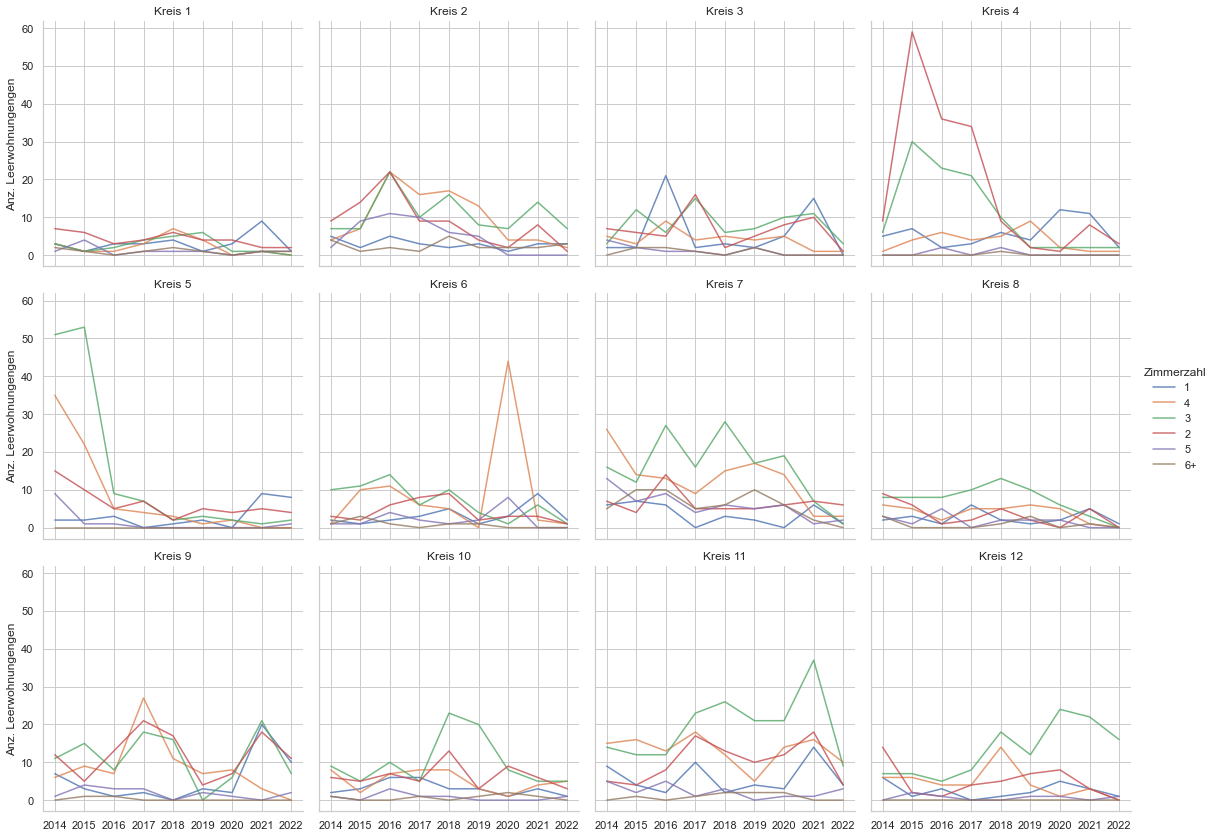

In [78]:
g = sns.FacetGrid(myAggScat.reset_index(), col="KreisLang", hue="Zimmerzahl", col_wrap=4, height=4,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_AnzWhgLeer",alpha=.8,label='label2')

#Layout
g.set_axis_labels("","Anz. Leerwohnungengen")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
#g.tight_layout()

g.add_legend()

##### Entwicklung nach Stadtquartieren

In [79]:
myAggScat = data2betested.loc["2014":year_today]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str','QuarSort', 'QuarLang','Zimmerzahl']) \
    .agg(sum_AnzWhgLeer =('AnzWhgLeer', 'sum')) \
    .sort_values('QuarSort', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisSort,KreisLang,Zimmerzahl,sum_AnzWhgLeer
0,2022-01-01,2022-06-01,1,Kreis 1,1,1
1,2022-01-01,2022-06-01,1,Kreis 1,2,2
2,2022-01-01,2022-06-01,9,Kreis 9,5,2


In [80]:
#Link to Seaborn API Description:
# https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid

In [ ]:
g = sns.FacetGrid(myAggScat.reset_index(), col="QuarLang", hue="Zimmerzahl", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_AnzWhgLeer",alpha=.8,label='label2')

#Layout
g.set_axis_labels("","Anz. Leerwohnungen")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
#g.tight_layout()

g.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Anzahl Wohnungen nach Zimmerzahl, Kreis und Quartier 2021

In [ ]:
data2betested.dtypes

In [ ]:
myTreemapAgg = data2betested.loc["2020": year_today]  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'KreisLang', 'Zimmerzahl']) \
    .agg(sum_AnzWhgLeer=('AnzWhgLeer', 'sum'),sum_AnzWhgBestand=('AnzWhgBestand', 'sum'))\
    .sort_values('sum_AnzWhgLeer', ascending=False) 

myTreemapAgg.reset_index().head(3)

In [ ]:
fig = px.treemap(myTreemapAgg.query('sum_AnzWhgLeer >0').reset_index(), path=[px.Constant("Anzahl Leerwohnungen nach Zimmerzahl, Kreis und Quartier"),'KreisLang', 'QuarLang','StichtagDatJahr', 'Zimmerzahl',]
                 , values='sum_AnzWhgLeer'
                 , color='QuarLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [ ]:
fig = px.treemap(myTreemapAgg.query('sum_AnzWhgLeer >0').reset_index(), path=[px.Constant("Anzahl Leerwohnungen nach Zimmerzahl, Kreis und Quartier"),'StichtagDatJahr', 'Zimmerzahl','KreisLang', 'QuarLang']
                 , values='sum_AnzWhgLeer'
                 , color='Zimmerzahl'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','1':'gold', '2':'#FCE1AA', '3':'#FDC59E', '4':'FEAA89','5':'#D4E3E3','6':'94D7E1','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="black")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=826&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

In [40]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [41]:
akt_wbev_quart = data2betested.loc["2021-11"].groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(
    {'AnzBestWir':'sum'}
)
akt_wbev_quart.head()


KeyError: '2021-11'

In [ ]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(akt_wbev_quart, on='QuarCd')

stadtquartiere_shapes_joined.head(2)


In [ ]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html